# Hab Dishab Sanbox Analysis

Answering random questions

In [70]:
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

from trial_class import *
from experiment_class import Experiment
from bouts_extension import *


In [71]:
# NAc: #15616F
# mPFC: #FFAF00

# NAc
experiment_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\nac"
csv_base_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\nac_csvs"
brain_region = '#15616F'

# mPFC
# experiment_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\mpfc"
# csv_base_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\mpfc_csvs"
# brain_region = '#FFAF00'

In [72]:
bout_definitions = [
    {'prefix': 'Short_Term', 'introduced': 'Short_Term_Introduced', 'removed': 'Short_Term_Removed'},
    {'prefix': 'Long_Term', 'introduced': 'Long_Term_Introduced', 'removed': 'Long_Term_Removed'},
    {'prefix': 'Novel', 'introduced': 'Novel_Introduced', 'removed': 'Novel_Removed'}
]


In [73]:
# groups csv + experiment data into one variable
experiment = Experiment(experiment_path, csv_base_path)

# batch process the data, removing the specified time segments for subjects
experiment.default_batch_process()

Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\nac\n6-240823-101436\Notes.txt
read from t=0s to t=1793.07s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\nac\n7-240824-062103\Notes.txt
read from t=0s to t=1803.56s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\nac\nn1-250120-063024\Notes.txt
read from t=0s to t=1833.87s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\nac\nn2-250120-072910\Notes.txt
read from t=0s to t=1774.16s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\nac\nn3-250121-074834\Notes.txt
read from t=0s to t=1856.87s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\nac\nn4-250121-084228\Notes.txt
read 

### Check if there is a second behavioral event when you take the peak nearest to first investigation. We want to ensure you are not taking the peak of a second behavioral event.

In [74]:
experiment.reset_all_behaviors()
experiment.group_extract_manual_annotations(bout_definitions=bout_definitions, first_only = False)

# total_avg_bout_duration = metadata_df["Average Bout Duration"].mean()
# print(f"Total Average Bout Duration: {total_avg_bout_duration:.4f}")
# Proceed with DA metric computation after all files are processed
experiment.compute_all_da_metrics(use_max_length=False,
                                  max_bout_duration=4, # total_avg_bout_duration 
                                  mode='standard')

Processing behaviors for n6-240823-101436...
Processing behaviors for n7-240824-062103...
Processing behaviors for nn1-250120-063024...
Processing behaviors for nn2-250120-072910...
Processing behaviors for nn3-250121-074834...
Processing behaviors for nn4-250121-084228...
Processing behaviors for nn5-250120-081227...
Processing behaviors for nn6-250120-085156...
Processing behaviors for nn7-250121-094048...
Processing behaviors for nn8-250121-101912...
Computing DA metrics for n6-240823-101436 ...
Computing DA metrics for n7-240824-062103 ...
Computing DA metrics for nn1-250120-063024 ...
Computing DA metrics for nn2-250120-072910 ...
Computing DA metrics for nn3-250121-074834 ...
Computing DA metrics for nn4-250121-084228 ...
Computing DA metrics for nn5-250120-081227 ...
Computing DA metrics for nn6-250120-085156 ...
Computing DA metrics for nn7-250121-094048 ...
Computing DA metrics for nn8-250121-101912 ...


In [75]:
exp_da_dict = get_trial_dataframes(experiment)
desired_bouts = ['s1-1', 's1-2', 's1-3', 's1-4', 's1-5', 's2-1']

In [76]:
def count_peaks_past_next_investigation(exp_da_dict, behavior="Investigation"):
    """
    For each subject and bout, check if the first behavior's peak occurs
    after the second behavior's onset. Returns a nested dict:
    
    {
      subject_id: {
        bout_label: {
          "overlap": True/False,
          "absolute_peak_time": float,
          "second_onset": float
        },
        ...
      },
      ...
    }
    """
    from collections import defaultdict

    overlaps = defaultdict(dict)

    for subj, df in exp_da_dict.items():
        df_b = df[df["Behavior"] == behavior].copy()
        df_b.sort_values("Event_Start", inplace=True)

        for bout, g in df_b.groupby("Bout"):
            g = g.reset_index(drop=True)

            if len(g) < 2:
                overlaps[subj][bout] = {
                    "overlap": False,
                    "absolute_peak_time": None,
                    "second_onset": None
                }
                continue

            first = g.loc[0]
            second_onset = g.loc[1, "Event_Start"]
            absolute_peak_time = first["Event_Start"] + first["Time of Max Peak"]

            overlaps[subj][bout] = {
                "overlap": absolute_peak_time > second_onset,
                "absolute_peak_time": absolute_peak_time,
                "second_onset": second_onset
            }

    return overlaps


In [77]:
overlaps = count_peaks_past_next_investigation(exp_da_dict)

In [78]:
for subj, bouts in overlaps.items():
    for bout, info in bouts.items():
        if info["overlap"]:
            print(f"⚠️ {subj} / {bout}: 1st peak ({info['absolute_peak_time']:.2f}s) ≥ 2nd onset ({info['second_onset']:.2f}s)")


In [79]:
# exp_da_dict['nn6']

### Quantify frequency of dopamine peaks throughout time, since the mPFC DA preprint shows that frequency was higher for novel contexts. 

In [80]:
bout_defs = [
    {'prefix': 'Short_Term', 'introduced': 'Short_Term_Introduced', 'removed': 'Short_Term_Removed'},
    {'prefix': 'Long_Term', 'introduced': 'Long_Term_Introduced', 'removed': 'Long_Term_Removed'},
    {'prefix': 'Novel', 'introduced': 'Novel_Introduced', 'removed': 'Novel_Removed'}
]

bout_bounds_df = experiment.get_bout_boundaries_df(bout_defs)
print(bout_bounds_df.head())


  Subject          Bout  Bout_Start_s  Bout_End_s
0      n6  Short_Term-1         184.0       786.0
1      n6  Short_Term-2        1473.7      1775.3
2      n6   Long_Term-1         855.7      1156.0
3      n6       Novel-1        1165.4      1468.2
4      n7  Short_Term-1         183.3       785.8


In [81]:
# 1) Get bout definitions and boundaries
bout_defs = [
    {'prefix': 'Short_Term', 'introduced': 'Short_Term_Introduced', 'removed': 'Short_Term_Removed'},
    {'prefix': 'Long_Term', 'introduced': 'Long_Term_Introduced', 'removed': 'Long_Term_Removed'},
    {'prefix': 'Novel', 'introduced': 'Novel_Introduced', 'removed': 'Novel_Removed'}
]
bout_bounds_df = experiment.get_bout_boundaries_df(bout_defs)

# 2) Plot traces with both behavior spans and bout markers
# experiment.plot_behavior_and_bouts(bout_bounds_df, behavior_name="Investigation")


In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def detect_spontaneous_events(
    timestamps: np.ndarray,
    signal: np.ndarray,
    threshold_factor: float = 3.0,
    min_distance_s: float = 1.0,
    min_width_s:    float = 0.5
):
    """
    Detect peaks using a MAD‐threshold, plus a minimum inter‐peak interval
    and a minimum peak width.
    Returns:
      peak_times (np.ndarray),
      peak_amps (np.ndarray),
      peak_widths (np.ndarray, in seconds)
    """
    # 1) compute baseline + MAD
    med = np.median(signal)
    mad = np.median(np.abs(signal - med))
    thresh = med + threshold_factor * mad

    # 2) convert time criteria into sample counts (assumes uniform dt)
    dt = np.median(np.diff(timestamps))
    min_dist_samples  = int(np.round(min_distance_s / dt))
    min_width_samples = int(np.round(min_width_s    / dt))

    # 3) detect peaks
    peaks, props = find_peaks(
        signal,
        height=thresh,
        distance=min_dist_samples,
        width=min_width_samples
    )

    # 4) collect outputs
    peak_times  = timestamps[peaks]
    peak_amps   = signal[peaks]
    peak_widths = props["widths"] * dt

    return peak_times, peak_amps, peak_widths

def build_event_dataframe(
    experiment,
    threshold_factor: float = 3.0,
    min_distance_s:    float = 1.0,
    min_width_s:       float = 0.5
) -> pd.DataFrame:
    """
    Loop through experiment.trials, run detect_spontaneous_events on each trial,
    and return a DataFrame with columns:
      Subject | Trial | Event_Time | Amplitude | Width_s
    """
    rows = []
    for trial_name, trial in experiment.trials.items():
        ts  = np.array(trial.timestamps)
        sig = np.array(trial.zscore)   # or trial.dff if you prefer raw ΔF/F

        peak_times, peak_amps, peak_widths = detect_spontaneous_events(
            ts, sig,
            threshold_factor=threshold_factor,
            min_distance_s=min_distance_s,
            min_width_s=min_width_s
        )

        for t, a, w in zip(peak_times, peak_amps, peak_widths):
            rows.append({
                "Subject":    trial.subject_name,
                "Trial":      trial_name,
                "Event_Time": t,
                "Amplitude":  a,
                "Width_s":    w
            })

    return pd.DataFrame(rows)


def plot_all_traces_with_bouts_and_peaks(
    experiment,
    bout_bounds_df: pd.DataFrame,
    peaks_df: pd.DataFrame = None,
    behavior_name: str = "all",
    start_time: float = 30.0
):
    """
    Plots each trial's z-score with:
    - behavior spans (green for Investigation, gray for others),
    - lightly shaded blue spans for each bout,
    - optional red dots for spontaneous events (peaks_df).

    Parameters:
    - experiment: Experiment instance containing trials
    - bout_bounds_df: DataFrame with Subject, Bout_Start_s, and Bout_End_s
    - peaks_df: Optional DataFrame with Trial and Event_Time (and Amplitude)
    - behavior_name: Name of the behavior to span ("all" for all)
    - start_time: Minimum x-axis time for plotting
    """
    num_trials = len(experiment.trials)
    fig, axes = plt.subplots(nrows=num_trials,
                             figsize=(12, 3 * num_trials),
                             sharex=False)
    if num_trials == 1:
        axes = [axes]

    for ax, (trial_name, trial) in zip(axes, experiment.trials.items()):
        ax.set_title(trial_name)

        # 1. Plot z-score
        ax.plot(trial.timestamps, trial.zscore, color="black", lw=1, label="z-score")

        # 2. Behavior spans
        dfb = trial.behaviors
        if dfb is not None and not dfb.empty:
            if behavior_name != "all":
                dfb = dfb[dfb["Behavior"] == behavior_name]
            for _, row in dfb.iterrows():
                color = "green" if row["Behavior"] == "Investigation" else "gray"
                ax.axvspan(row["Event_Start"], row["Event_End"], color=color, alpha=0.3)

        # 3. Lightly shaded bouts in blue
        bounds = bout_bounds_df[bout_bounds_df["Subject"] == trial.subject_name]
        for _, row in bounds.iterrows():
            ax.axvspan(row["Bout_Start_s"], row["Bout_End_s"], color="skyblue", alpha=0.3)

        # 4. Peak events
        if peaks_df is not None:
            ev = peaks_df[peaks_df["Trial"] == trial_name]
            ax.scatter(ev["Event_Time"],
                       ev["Amplitude"],
                       color="red",
                       s=30,
                       zorder=5,
                       label="Peaks")

        # 5. Final formatting
        ax.set_xlim(start_time, trial.timestamps[-1])
        ax.tick_params(axis='x', labelbottom=True)
        ax.legend(loc='upper right', fontsize='small')

    plt.tight_layout()
    plt.show()


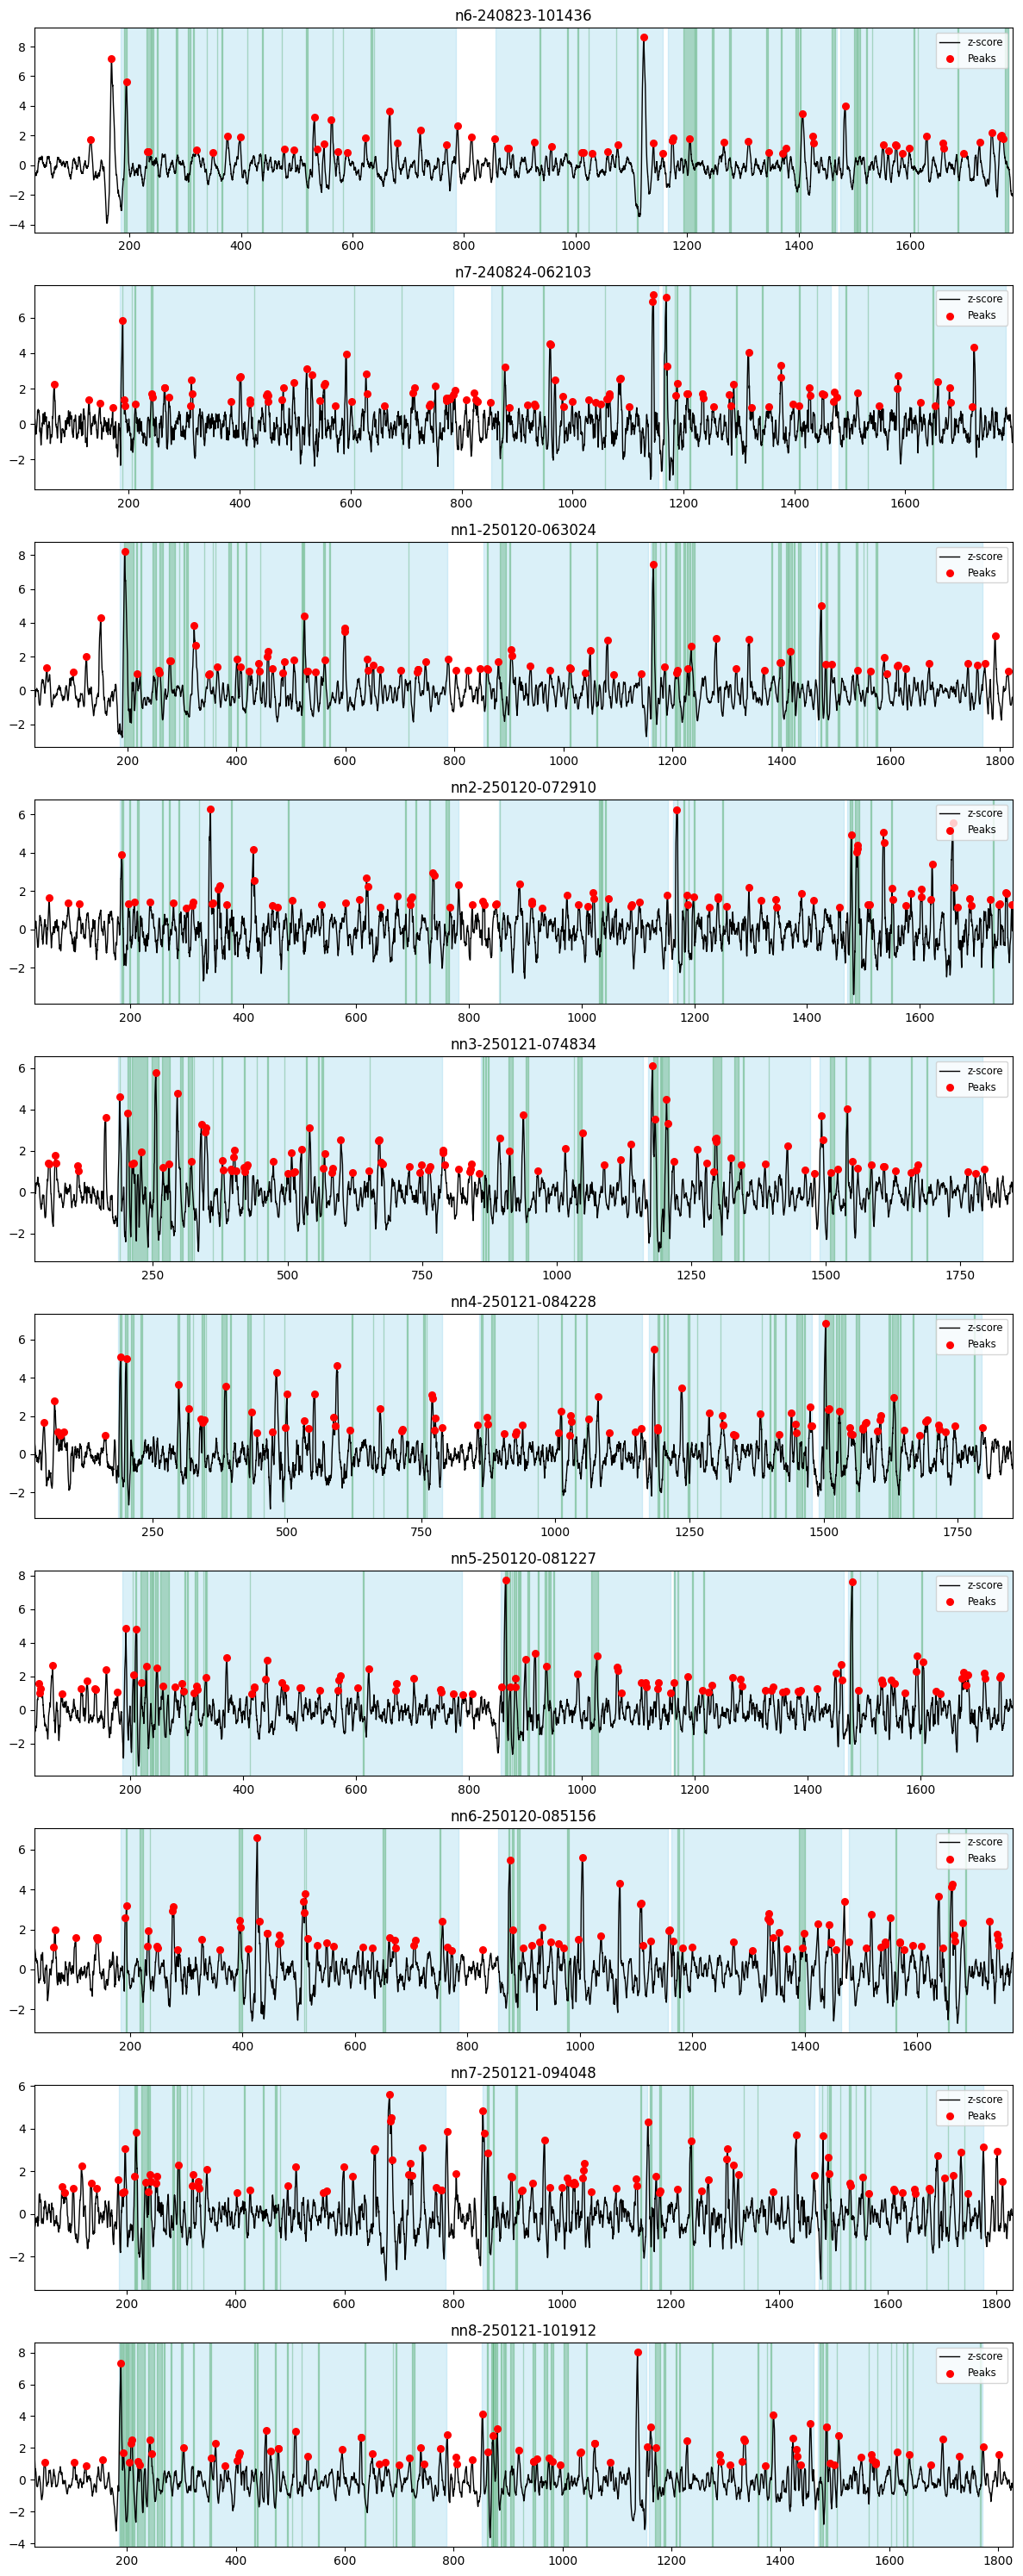

In [83]:
bout_defs = [
    {'prefix': 'Short_Term', 'introduced': 'Short_Term_Introduced', 'removed': 'Short_Term_Removed'},
    {'prefix': 'Long_Term', 'introduced': 'Long_Term_Introduced', 'removed': 'Long_Term_Removed'},
    {'prefix': 'Novel', 'introduced': 'Novel_Introduced', 'removed': 'Novel_Removed'}
]

bout_bounds_df = experiment.get_bout_boundaries_df(bout_defs)
short_cutoffs = {}
for subj in bout_bounds_df['Subject'].unique():
    # find the row where Bout == 'Short_Term-1' for this subject
    row = bout_bounds_df[
        (bout_bounds_df['Subject'] == subj) & 
        (bout_bounds_df['Bout'] == 'Short_Term-1')
    ]
    if not row.empty:
        # bout_start_s is the start of Short_Term-1
        start_s = float(row['Bout_Start_s'].iloc[0])
        short_cutoffs[subj] = start_s + 300.0  # 5 minutes = 300 s
    else:
        # if no Short_Term-1 found, effectively drop all peaks (set cutoff = 0)
        short_cutoffs[subj] = 0.0
peaks_df = build_event_dataframe(experiment,   
                                threshold_factor=2,   # e.g. 2.5 × MAD
                                min_distance_s=0.5,     # at least 1 second between peaks
                                min_width_s=0.3         # each peak ≥ 0.3 s wide
)


plot_all_traces_with_bouts_and_peaks(experiment, bout_bounds_df, peaks_df, behavior_name='Investigation')


In [84]:
peaks_df

,Subject,Trial,Event_Time,Amplitude,Width_s
0,n6,n6-240823-101436,130.823944,1.761279,6.450475
1,n6,n6-240823-101436,167.933703,7.190692,8.169848
2,n6,n6-240823-101436,194.668458,5.599135,5.808826
3,n6,n6-240823-101436,232.085909,0.902954,0.512386
4,n6,n6-240823-101436,233.202642,0.931120,20.378482
...,...,...,...,...,...
976,nn8,nn8-250121-101912,1675.864932,0.956224,4.028850
977,nn8,nn8-250121-101912,1698.093432,2.543516,4.916094
978,nn8,nn8-250121-101912,1729.248918,1.503063,3.950601
979,nn8,nn8-250121-101912,1773.121009,2.070864,4.635624


In [85]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Build a little table of recording durations per subject
#    (each trial’s duration minus the first 30 s)
rows = []
for trial_name, trial in experiment.trials.items():
    subj = trial.subject_name
    # total trial time (s) after cutting out the first 30 s
    dur_s = trial.timestamps[-1] - 30.0
    rows.append({'Subject': subj, 'Duration_s': dur_s})
dur_df = pd.DataFrame(rows)

# 2) Sum durations across trials for each subject, convert to minutes
time_per_subj = (
    dur_df
    .groupby('Subject', as_index=False)['Duration_s']
    .sum()
    .assign(Duration_min = lambda df: df['Duration_s'] / 60)
)

# 3) Count peaks per subject (only those after 30 s)
counts = (
    peaks_df[peaks_df['Event_Time'] >= 30]
    .groupby('Subject', as_index=False)
    .size()
    .rename(columns={'size':'Num_Peaks'})
)

# 4) Merge counts & total time → compute rate
rate_df = pd.merge(counts, time_per_subj, on='Subject')
rate_df['Peaks_per_min'] = rate_df['Num_Peaks'] / rate_df['Duration_min']

print(rate_df)


  Subject  Num_Peaks   Duration_s  Duration_min  Peaks_per_min
0      n6         67  1752.937646     29.215627       2.293293
1      n7        115  1763.381463     29.389691       3.912937
2     nn1         89  1793.706280     29.895105       2.977076
3     nn2         97  1734.063279     28.901055       3.356279
4     nn3        105  1816.733009     30.278883       3.467763
5     nn4         93  1821.640344     30.360672       3.063173
6     nn5        109  1732.804987     28.880083       3.774227
7     nn6        106  1739.599760     28.993329       3.656013
8     nn7        108  1798.991103     29.983185       3.602019
9     nn8         92  1796.474521     29.941242       3.072685


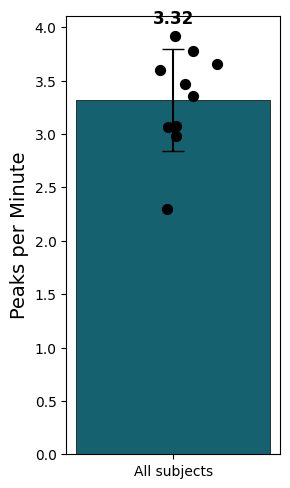

In [86]:
import numpy as np
import matplotlib.pyplot as plt

# --- assume you already have rate_df
mean_rate = rate_df['Peaks_per_min'].mean()
std_rate  = rate_df['Peaks_per_min'].std(ddof=1)

fig, ax = plt.subplots(figsize=(3, 5))

# 1) draw bar with error bar
bar_x = 0
bar_width = 0.25
ax.bar(bar_x, mean_rate,
       yerr=std_rate,
       capsize=8,
       width=bar_width,
       color=brain_region,
       edgecolor='black',
       linewidth=0.5)

# 2) add mean value as text above the bar
ax.text(bar_x, mean_rate + std_rate + 0.2, f"{mean_rate:.2f}",
        ha='center', va='bottom', fontsize=12, fontweight='bold')

# 3) overlay individual subject dots (with slight jitter)
x_jitter = np.random.normal(bar_x, 0.03, size=len(rate_df))
ax.scatter(x_jitter, rate_df['Peaks_per_min'],
           color='black', s=50, zorder=5)

# 4) cosmetics
ax.set_xticks([bar_x])
ax.set_xticklabels(['All subjects'])
ax.set_ylabel('Peaks per Minute', fontsize=14)
# ax.set_title('Spontaneous Event Rate', fontsize=16)

plt.tight_layout()
plt.show()


In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# 1) Build a little table of recording durations per subject
#    (each trial’s duration minus the first 30 s)
dur_rows = []
for trial_name, trial in experiment.trials.items():
    subj = trial.subject_name
    dur_s = trial.timestamps[-1] - 30.0
    dur_rows.append({'Subject': subj, 'Duration_s': dur_s})
dur_df = pd.DataFrame(dur_rows)

# 2) Sum durations across trials for each subject, convert to minutes
time_per_subj = (
    dur_df
    .groupby('Subject', as_index=False)['Duration_s']
    .sum()
    .assign(Duration_min=lambda df: df['Duration_s'] / 60)
)

# 3) Count investigation bouts per subject (only those after 30 s)
beh_rows = []
for trial_name, trial in experiment.trials.items():
    subj = trial.subject_name
    # filter only Investigation events in the manual annotations
    if trial.behaviors is not None and not trial.behaviors.empty:
        inv = trial.behaviors[
            (trial.behaviors['Behavior'] == 'Investigation') &
            (trial.behaviors['Event_Start'] >= 30)
        ]
        n_inv = len(inv)
    else:
        n_inv = 0
    beh_rows.append({'Subject': subj, 'Num_Behaviors': n_inv})
behav_df = pd.DataFrame(beh_rows)

# 4) Merge & compute behaviors per minute
behavior_df = pd.merge(behav_df, time_per_subj, on='Subject')
behavior_df['Behaviors_per_min'] = behavior_df['Num_Behaviors'] / behavior_df['Duration_min']

print(behavior_df)


  Subject  Num_Behaviors   Duration_s  Duration_min  Behaviors_per_min
0      n6             42  1752.937646     29.215627           1.437587
1      n7             21  1763.381463     29.389691           0.714536
2     nn1             47  1793.706280     29.895105           1.572164
3     nn2             28  1734.063279     28.901055           0.968823
4     nn3             37  1816.733009     30.278883           1.221974
5     nn4             48  1821.640344     30.360672           1.580993
6     nn5             38  1732.804987     28.880083           1.315786
7     nn6             18  1739.599760     28.993329           0.620832
8     nn7             34  1798.991103     29.983185           1.133969
9     nn8             59  1796.474521     29.941242           1.970526


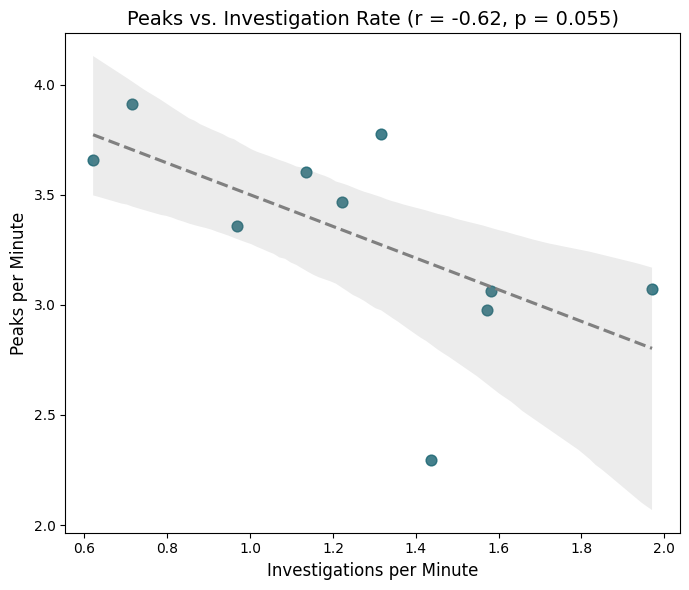

In [88]:
# merge your two rates
merged_df = pd.merge(rate_df, behavior_df[['Subject','Behaviors_per_min']], on='Subject')

plt.figure(figsize=(7,6))
sns.regplot(
    data=merged_df,
    x='Behaviors_per_min',
    y='Peaks_per_min',
    color=brain_region,               # use your region color
    scatter_kws={'s':60, 'alpha':0.8},
    line_kws={'linestyle':'--', 'color':'gray'}
)

# annotate Pearson r
r, p = pearsonr(merged_df['Behaviors_per_min'], merged_df['Peaks_per_min'])
plt.title(f'Peaks vs. Investigation Rate (r = {r:.2f}, p = {p:.3f})', fontsize=14)
plt.xlabel('Investigations per Minute', fontsize=12)
plt.ylabel('Peaks per Minute', fontsize=12)
plt.tight_layout()
plt.show()


In [89]:
import numpy as np
import pandas as pd

# 1) define your bout definitions & get boundaries
bout_defs = [
    {'prefix': 'Short_Term', 'introduced': 'Short_Term_Introduced', 'removed': 'Short_Term_Removed'},
    {'prefix': 'Long_Term', 'introduced': 'Long_Term_Introduced', 'removed': 'Long_Term_Removed'},
    {'prefix': 'Novel', 'introduced': 'Novel_Introduced', 'removed': 'Novel_Removed'}
]
bout_bounds_df = experiment.get_bout_boundaries_df(bout_defs)

# 2) cut off first 30 s and restrict to peaks after that
peaks_cut = peaks_df[peaks_df.Event_Time >= 30].copy()

# 3) build per-subject rates
rows = []
for subj in peaks_cut.Subject.unique():
    subp   = peaks_cut[peaks_cut.Subject == subj]
    bounds = bout_bounds_df[bout_bounds_df.Subject == subj]\
                 .sort_values('Bout_Start_s')
    
    # --- Bout windows ---
    # total bout duration in seconds
    bout_dur_s = (bounds.Bout_End_s - bounds.Bout_Start_s).sum()
    # count of peaks inside any bout
    bout_count = sum(
        ((subp.Event_Time >= row.Bout_Start_s) & 
         (subp.Event_Time <= row.Bout_End_s)).sum()
        for _, row in bounds.iterrows()
    )
    # peaks per minute in‐bout
    rate_bout = bout_count / (bout_dur_s/60) if bout_dur_s>0 else np.nan

    # --- ITI windows (between end of this bout and start of next) ---
    iti_dur_s = 0
    iti_count = 0
    # get all the inter‐bout segments
    for i, row in enumerate(bounds.itertuples()):
        start = row.Bout_End_s
        # next bout’s start, or trial end if last
        if i+1 < len(bounds):
            end = bounds.iloc[i+1].Bout_Start_s
        else:
            # assume each trial is same length: grab max timestamp from any trial this subj
            trials = experiment.trials
            # find one trial for this subject:
            trial_name = next(n for n,t in trials.items() if t.subject_name==subj)
            end = experiment.trials[trial_name].timestamps[-1]
        iti_dur_s += (end - start)
        iti_count += ((subp.Event_Time > start) & (subp.Event_Time < end)).sum()

    rate_iti = iti_count / (iti_dur_s/60) if iti_dur_s>0 else np.nan

    rows.append({
        'Subject':    subj,
        'Rate_Bout':  rate_bout,
        'Rate_ITI':   rate_iti
    })

df = pd.DataFrame(rows)


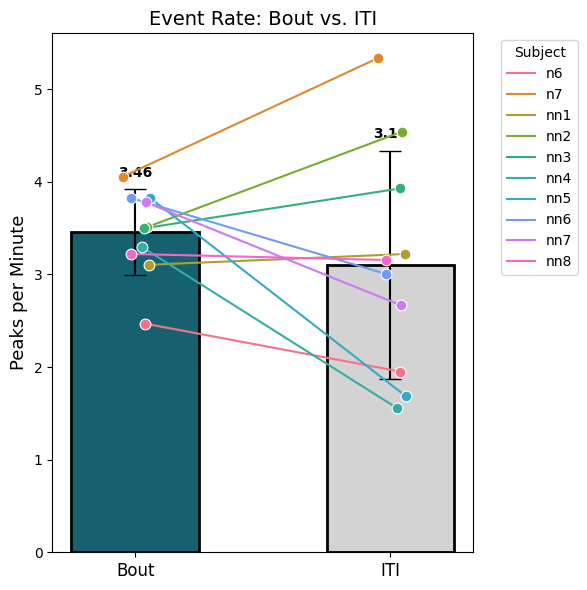

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# assume you already have:
#   peaks_df       with columns ['Subject','Trial','Event_Time',...]
#   bout_bounds_df with columns ['Subject','Bout_Start_s','Bout_End_s']
#   experiment     your Experiment instance
#   brain_region   your color for the "Bout" bar (e.g. '#15616F')

# — (steps 1–4 from before to build df with Rate_Bout & Rate_ITI) —

# ... [snip: same code to produce `df` with columns Subject, Rate_Bout, Rate_ITI] ...

# 5) compute means & stds
mean_bout = df['Rate_Bout'].mean()
std_bout  = df['Rate_Bout'].std(ddof=1)
mean_iti  = df['Rate_ITI'].mean()
std_iti   = df['Rate_ITI'].std(ddof=1)

# 6) color map for subjects
subjects = df['Subject'].unique()
palette = dict(zip(subjects, sns.color_palette("husl", len(subjects))))

# 7) plotting
fig, ax = plt.subplots(figsize=(6, 6))
bars_x = np.array([0, 1])
bar_w = 0.5

# draw bars
ax.bar(0, mean_bout, yerr=std_bout, capsize=8, width=bar_w,
       color=brain_region, edgecolor='black', linewidth=2)
ax.text(0, mean_bout + std_bout + 0.1, f"{mean_bout:.2f}",
        ha='center', va='bottom', fontweight='bold')

ax.bar(1, mean_iti, yerr=std_iti, capsize=8, width=bar_w,
       color='lightgray', edgecolor='black', linewidth=2)
ax.text(1, mean_iti + std_iti + 0.1, f"{mean_iti:.2f}",
        ha='center', va='bottom', fontweight='bold')

# overlay each subject: line + dots
for subj in subjects:
    row = df[df.Subject == subj].iloc[0]
    y_b = row['Rate_Bout']
    y_i = row['Rate_ITI']
    # small horizontal jitter so lines don’t perfectly overlap
    jitter = np.random.uniform(-0.08, 0.08)
    x_b, x_i = 0 + jitter, 1 + jitter

    # connect with a thin line
    ax.plot([x_b, x_i], [y_b, y_i],
            color=palette[subj], linewidth=1.5, zorder=4, label=subj)
    # draw end‐point markers
    ax.scatter([x_b, x_i], [y_b, y_i],
               color=palette[subj], s=60, edgecolor='white', linewidth=0.8, zorder=5)

# cosmetics & legend
ax.set_xticks(bars_x)
ax.set_xticklabels(['Bout', 'ITI'], fontsize=12)
ax.set_ylabel('Peaks per Minute', fontsize=13)
ax.set_title('Event Rate: Bout vs. ITI', fontsize=14)

# only one legend entry per subject
handles, labels = ax.get_legend_handles_labels()
# remove duplicates
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),
          title='Subject', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In_Bout
True     869
False    112
Name: count, dtype: int64


C:\Users\alber\AppData\Local\Temp\ipykernel_37988\4268827441.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='In_Bout', y='Amplitude', data=df,
c:\Users\alber\anaconda3\envs\photometry\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 33.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\alber\anaconda3\envs\photometry\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 26.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


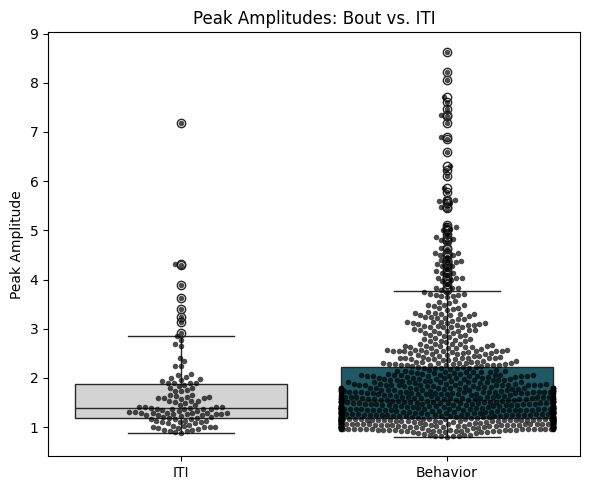

In_Bout     False     True 
Subject                    
n6       1.904357  1.421433
n7       1.375766  1.634775
nn1      1.353912  1.448565
nn2      1.335206  1.552213
nn3      1.306874  1.409077
nn4      1.412000  1.659286
nn5      1.239084  1.597898
nn6      1.601455  1.439782
nn7      1.605120  1.645798
nn8      1.267791  1.689221
Wilcoxon p = 0.193


In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon

# 1) Copy + label each peak as in‐bout or ITI
df = peaks_df.copy()
df['In_Bout'] = False

for _, br in bout_bounds_df.iterrows():
    m = (
      (df['Subject'] == br['Subject']) &
      (df['Event_Time'] >= br['Bout_Start_s']) &
      (df['Event_Time'] <= br['Bout_End_s'])
    )
    df.loc[m, 'In_Bout'] = True

# sanity check
print(df['In_Bout'].value_counts())

# 2) Plot amplitude distributions
plt.figure(figsize=(6,5))
sns.boxplot(x='In_Bout', y='Amplitude', data=df,
            palette=['lightgray', brain_region])
sns.swarmplot(x='In_Bout', y='Amplitude', data=df,
              color='k', alpha=0.7, size=4)

plt.xticks([0,1], ['ITI','Behavior'])
plt.ylabel('Peak Amplitude')
plt.xlabel('')
plt.title('Peak Amplitudes: Bout vs. ITI')
plt.tight_layout()
plt.show()

# 3) (Optional) Paired summary per subject and test
#    Compute each mouse’s median amplitude in‐bout vs ITI
subj_stats = df.groupby(['Subject','In_Bout'])['Amplitude']\
               .median()\
               .unstack()

print(subj_stats)

# paired Wilcoxon signed‐rank test
stat, p = wilcoxon(subj_stats[False], subj_stats[True])
print(f"Wilcoxon p = {p:.3f}")


In [92]:
def compute_peak_rates(
    peaks_df: pd.DataFrame,
    bout_bounds_df: pd.DataFrame,
    event_type: str,
    before_win: float,
    after_win: float = 1.0,
    cutoff_s: float = 30.0
) -> pd.Series:
    """
    Returns peaks per second around each Entry or Removal.
    For each subject:
      - window length = before_win + after_win
      - total_time = n_events * window_length
      - rate = count_peaks_in_windows / total_time
    """
    assert event_type in ('Entry','Removal')
    subjects = peaks_df['Subject'].unique()
    rates = {}
    window_len = before_win + after_win

    for subj in subjects:
        subp = peaks_df[
            (peaks_df.Subject == subj) &
            (peaks_df.Event_Time >= cutoff_s)
        ]
        # grab each event’s timestamp
        bb = bout_bounds_df[bout_bounds_df.Subject == subj]
        times = bb['Bout_Start_s'] if event_type=='Entry' else bb['Bout_End_s']
        n_events = len(times)
        if n_events == 0 or window_len <= 0:
            rates[subj] = 0.0
            continue

        # count how many peaks fall in any of the windows
        count = 0
        for t in times:
            m = (subp.Event_Time >= t - before_win) & (subp.Event_Time <= t + after_win)
            count += m.sum()

        total_time = n_events * window_len
        rates[subj] = count / total_time

    return pd.Series(rates, name=event_type)


C:\Users\alber\AppData\Local\Temp\ipykernel_37988\4195324089.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap       = plt.cm.get_cmap('tab20', len(subjects))


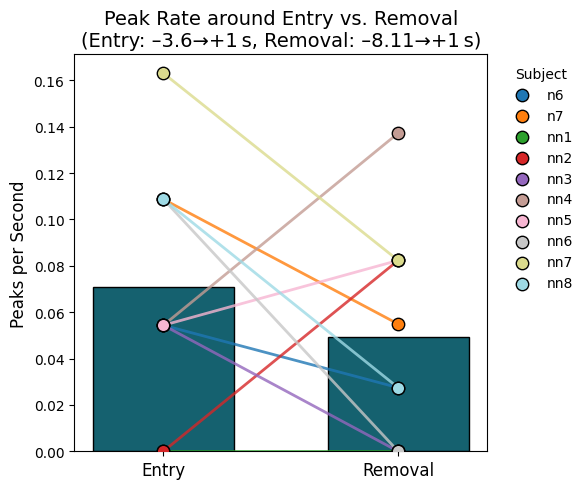

In [93]:
entry_rate   = compute_peak_rates(peaks_df, bout_bounds_df,
                                  event_type='Entry',
                                  before_win=3.6,
                                  after_win=1.0)

removal_rate = compute_peak_rates(peaks_df, bout_bounds_df,
                                  event_type='Removal',
                                  before_win=8.11,
                                  after_win=1.0)

# combine
df_rate = pd.concat([entry_rate, removal_rate], axis=1)
conditions = df_rate.columns.tolist()   # ['Entry','Removal']
subjects   = df_rate.index.tolist()
cmap       = plt.cm.get_cmap('tab20', len(subjects))
subject_colors = {s: cmap(i) for i,s in enumerate(subjects)}

fig, ax = plt.subplots(figsize=(6,5))
x = np.arange(len(conditions))
bar_w = 0.6

# gray bars = group means
means = df_rate.mean(axis=0)
ax.bar(x, means, width=bar_w, color=brain_region, edgecolor='k')

# lines + dots per subject
for subj in subjects:
    y = df_rate.loc[subj].values
    ax.plot(x, y, '-', color=subject_colors[subj], lw=2, alpha=0.8, zorder=3)
    ax.scatter(x, y,
               color=subject_colors[subj],
               edgecolor='k', s=80, zorder=4,
               label=subj)

# legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),
          title='Subject',
          bbox_to_anchor=(1.02,1), loc='upper left', frameon=False)

ax.set_xticks(x)
ax.set_xticklabels(conditions, fontsize=12)
ax.set_ylabel('Peaks per Second', fontsize=12)
ax.set_title('Peak Rate around Entry vs. Removal\n(Entry: –3.6→+1 s, Removal: –8.11→+1 s)', fontsize=14)
plt.tight_layout()
plt.show()


C:\Users\alber\AppData\Local\Temp\ipykernel_37988\2349751109.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(subjects))


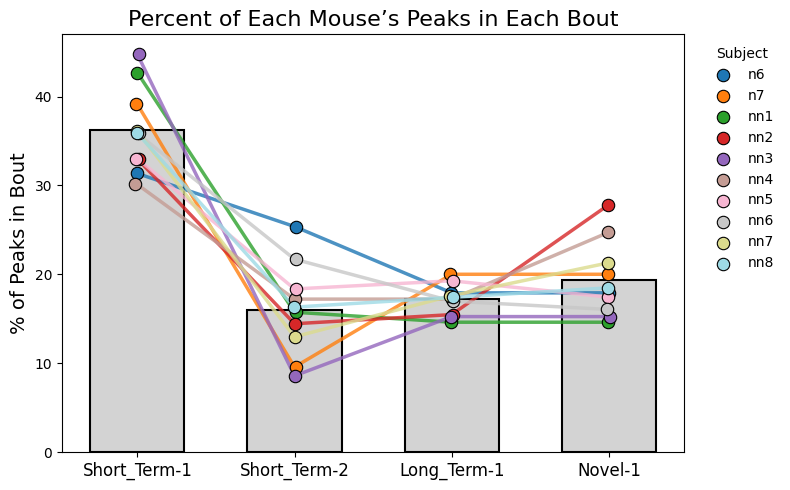

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1) Define which bouts to include, in order

bouts = ['Short_Term-1', 'Short_Term-2', 'Long_Term-1', 'Novel-1']


# --- 2) Build a table of % peaks per bout per subject
subjects = peaks_df['Subject'].unique()
pct = {bout: {} for bout in bouts}

# ignore first 30 s
peaks_df = peaks_df[peaks_df.Event_Time >= 30]

for subj in subjects:
    subp = peaks_df[peaks_df.Subject == subj]
    total = len(subp)
    for bout in bouts:
        # get that subject’s boundaries for this bout
        bb = bout_bounds_df[
            (bout_bounds_df.Subject == subj) &
            (bout_bounds_df.Bout == bout)
        ]
        # count peaks inside any window (there should only be one row per bout)
        count = 0
        for _, row in bb.iterrows():
            count += ((subp.Event_Time >= row.Bout_Start_s) &
                      (subp.Event_Time <= row.Bout_End_s)).sum()
        pct[bout][subj] = (count / total * 100) if total else 0

# DataFrame: rows=bouts, cols=subjects
count_df = pd.DataFrame(pct).T  # shape (6, n_subjects)

# --- 3) Compute the mean % across subjects for each bout
mean_pct = count_df.mean(axis=1)

# --- 4) Pick distinct colors for each mouse
cmap = plt.cm.get_cmap("tab20", len(subjects))
subject_colors = {subj: cmap(i) for i, subj in enumerate(subjects)}

# --- 5) Plot
fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(len(bouts))
bar_w = 0.6

# a) gray bars = means
ax.bar(x, mean_pct, width=bar_w,
       color="lightgray", edgecolor="black", linewidth=1.5)

# b) lines connecting each mouse
for subj in subjects:
    y = count_df[subj].values
    ax.plot(x, y,
            color=subject_colors[subj],
            linewidth=2.5, alpha=0.8, zorder=3)

# c) colored dots for each mouse
for i, bout in enumerate(bouts):
    for subj in subjects:
        y = count_df.loc[bout, subj]
        jitter = np.random.uniform(-bar_w*0.02, bar_w*0.02)
        ax.scatter(i + jitter, y,
                   color=subject_colors[subj],
                   s=80, edgecolor="black", linewidth=0.8,
                   zorder=4, label=subj)

# d) legend (one entry per mouse)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),
          title="Subject", bbox_to_anchor=(1.02,1),
          loc="upper left", frameon=False)

# e) labels & formatting
ax.set_xticks(x)
ax.set_xticklabels(bouts, fontsize=12)
ax.set_ylabel("% of Peaks in Bout", fontsize=14)
ax.set_title("Percent of Each Mouse’s Peaks in Each Bout", fontsize=16)
plt.tight_layout()
plt.show()


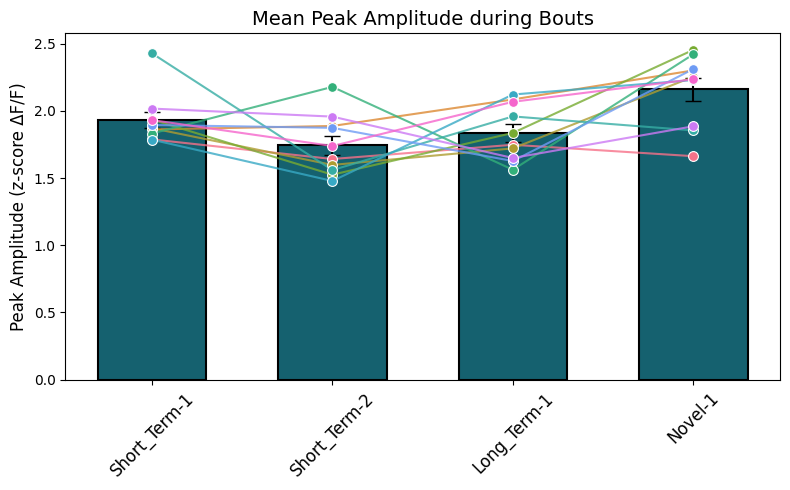

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ── 1) set up your bouts & subjects ────────────────────────────────────────
bouts = ['Short_Term-1', 'Short_Term-2', 'Long_Term-1', 'Novel-1']
subjects = peaks_df['Subject'].unique()

# ── 2) build a table of mean‐peak‐amplitude per bout per subject ─────────
amps   = {bout: {} for bout in bouts}
peaks_cut = peaks_df[peaks_df['Event_Time'] >= 30]  # drop first 30 s

for subj in subjects:
    subp = peaks_cut[peaks_cut['Subject'] == subj]
    for bout in bouts:
        # grab that mouse’s bout window(s)
        bb = bout_bounds_df[
            (bout_bounds_df['Subject'] == subj) &
            (bout_bounds_df['Bout']    == bout)
        ]
        # collect all the amplitudes that fall inside any of those rows
        vals = []
        for _, row in bb.iterrows():
            m = ((subp['Event_Time'] >= row['Bout_Start_s']) &
                 (subp['Event_Time'] <= row['Bout_End_s']))
            vals.extend(subp.loc[m, 'Amplitude'].tolist())
        # mean of those, or NaN if none
        amps[bout][subj] = np.nanmean(vals) if vals else np.nan

# turn into DataFrame: rows=subjects, cols=bouts
amp_df = pd.DataFrame(amps)

# ── 3) compute group mean ± SEM for each bout ───────────────────────────────
means = amp_df.mean(axis=0)
sems  = amp_df.sem(axis=0)

# ── 4) pick one color per mouse ────────────────────────────────────────────
palette = sns.color_palette("husl", len(subjects))
subject_colors = dict(zip(subjects, palette))

# ── 5) plot ───────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8,5))
x     = np.arange(len(bouts))
bar_w = 0.6

# grey bars = group mean ± SEM
ax.bar(
    x, means,
    yerr=sems,
    capsize=6,
    width=bar_w,
    color=brain_region,
    edgecolor='black',
    linewidth=1.5
)

# one line + dot per mouse
for subj in subjects:
    y = amp_df.loc[subj, bouts].values
    ax.plot(
        x, y,
        '-',
        color=subject_colors[subj],
        linewidth=1.5, alpha=0.8
    )
    ax.scatter(
        x, y,
        color=subject_colors[subj],
        s=50,
        edgecolor='white',
        linewidth=0.8,
        zorder=5
    )

# cosmetics
ax.set_xticks(x)
ax.set_xticklabels(bouts, rotation=45, fontsize=12)
ax.set_ylabel('Peak Amplitude (z-score ΔF/F)', fontsize=12)
ax.set_title('Mean Peak Amplitude during Bouts', fontsize=14)
plt.tight_layout()
plt.show()


=== bout_bounds_df ===
   Subject          Bout  Bout_Start_s  Bout_End_s
0      n6  Short_Term-1         184.0       786.0
1      n6  Short_Term-2        1473.7      1775.3
2      n6   Long_Term-1         855.7      1156.0
3      n6       Novel-1        1165.4      1468.2
4      n7  Short_Term-1         183.3       785.8 

=== behavior_df (first 5 rows) ===
   Subject         Bout       Behavior  Event_Start  Event_End
0      n6  Long_Term-1       Approach        934.4    935.399
1      n6  Long_Term-1  Investigation        935.4    937.300
2      n6  Long_Term-1  Investigation        984.4    985.600
3      n6  Long_Term-1  Investigation       1003.7   1004.000
4      n6  Long_Term-1  Investigation       1023.1   1023.700 

=== peaks_df (first 5 rows) ===
   Subject             Trial  Event_Time  Amplitude    Width_s
0      n6  n6-240823-101436  130.823944   1.761279   6.450475
1      n6  n6-240823-101436  167.933703   7.190692   8.169848
2      n6  n6-240823-101436  194.668458   5.5

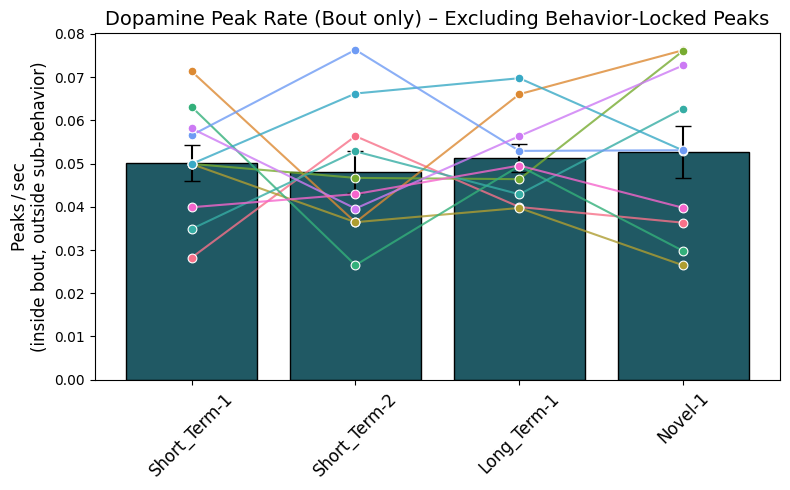

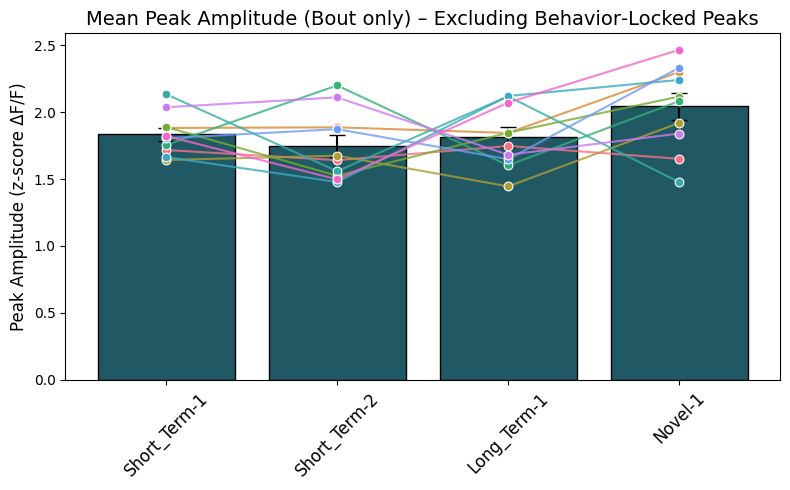

In [96]:
from collections import defaultdict

# Now exp_da_dict is a dict:  { subject_id: DataFrame_of_events_and_metrics, … }
exp_da_dict = get_trial_dataframes(experiment)

# ───── 2) Build `bout_bounds_df` (each row = one bout’s [Subject,Bout,Start,End]) ──
bout_bounds_df = experiment.get_bout_boundaries_df(bout_definitions)

# Example columns: ['Subject', 'Bout', 'Bout_Start_s', 'Bout_End_s']
# Print the first few lines to verify:
print("=== bout_bounds_df ===\n", bout_bounds_df.head(), "\n")

# ───── 3) Build a complete “behavior_df” that lists every (Subject,Bout,Event_Start,Event_End) ──
# Each trial in `experiment.trials` has a .behaviors DataFrame (with columns [Behavior, Event_Start, Event_End, Bout]).
# We will concatenate them all into one big DataFrame called behavior_df.

behavior_rows = []
for trial_name, trial in experiment.trials.items():
    subj = trial.subject_name
    dfb = trial.behaviors
    if dfb is None or dfb.empty:
        continue

    # Each row of dfb already has 'Behavior', 'Event_Start', 'Event_End', 'Bout'
    for idx, row in dfb.iterrows():
        behavior_rows.append({
            'Subject'    : subj,
            'Bout'       : row['Bout'],
            'Behavior'   : row['Behavior'],
            'Event_Start': float(row['Event_Start']),
            'Event_End'  : float(row['Event_End'])
        })

behavior_df = pd.DataFrame(behavior_rows)
print("=== behavior_df (first 5 rows) ===\n", behavior_df.head(), "\n")

# ───── 4) Detect spontaneous peaks in each trial’s z‐score trace ──────────────────
# We will reconstruct exactly the same logic you used (MAD threshold, min distance, min width).
def detect_spontaneous_events(
    timestamps: np.ndarray,
    signal: np.ndarray,
    threshold_factor: float = 3.0,
    min_distance_s: float = 1.0,
    min_width_s:    float = 0.5
):
    """
    (Exactly as before)
    Returns:
      peak_times (np.ndarray),
      peak_amps  (np.ndarray),
      peak_widths(np.ndarray, in seconds)
    """
    med = np.median(signal)
    mad = np.median(np.abs(signal - med))
    thresh = med + threshold_factor * mad

    dt = np.median(np.diff(timestamps))
    min_dist_samples  = int(np.round(min_distance_s / dt))
    min_width_samples = int(np.round(min_width_s    / dt))

    peaks, props = find_peaks(
        signal,
        height=thresh,
        distance=min_dist_samples,
        width=min_width_samples
    )

    peak_times  = timestamps[peaks]
    peak_amps   = signal[peaks]
    peak_widths = props["widths"] * dt

    return peak_times, peak_amps, peak_widths


def build_event_dataframe(
    experiment,
    threshold_factor: float = 3.0,
    min_distance_s:    float = 1.0,
    min_width_s:       float = 0.5
) -> pd.DataFrame:
    """
    Loops through experiment.trials, runs detect_spontaneous_events on each trial,
    and returns a DataFrame with columns:
      Subject | Trial | Event_Time | Amplitude | Width_s
    """
    rows = []
    for trial_name, trial in experiment.trials.items():
        subj = trial.subject_name
        ts   = np.array(trial.timestamps)
        sig  = np.array(trial.zscore)

        peak_times, peak_amps, peak_widths = detect_spontaneous_events(
            ts, sig,
            threshold_factor=threshold_factor,
            min_distance_s=min_distance_s,
            min_width_s=min_width_s
        )

        for t, a, w in zip(peak_times, peak_amps, peak_widths):
            rows.append({
                "Subject"   : subj,
                "Trial"     : trial_name,
                "Event_Time": float(t),
                "Amplitude" : float(a),
                "Width_s"   : float(w)
            })

    return pd.DataFrame(rows)

short_cutoffs = {}
for subj in bout_bounds_df['Subject'].unique():
    # find the row where Bout == 'Short_Term-1' for this subject
    row = bout_bounds_df[
        (bout_bounds_df['Subject'] == subj) & 
        (bout_bounds_df['Bout'] == 'Short_Term-1')
    ]
    if not row.empty:
        # bout_start_s is the start of Short_Term-1
        start_s = float(row['Bout_Start_s'].iloc[0])
        short_cutoffs[subj] = start_s + 300.0  # 5 minutes = 300 s
    else:
        # if no Short_Term-1 found, effectively drop all peaks (set cutoff = 0)
        short_cutoffs[subj] = 0.0
peaks_df = build_event_dataframe(
    experiment,
    threshold_factor=2.0,   # ← use 2×MAD (or 2.5, whatever you used previously)
    min_distance_s=0.5,
    min_width_s=0.3
)

# Show a few rows
print("=== peaks_df (first 5 rows) ===\n", peaks_df.head(), "\n")

# ───── 5) “Filter out” any peak that falls inside a sub‐behavioral event ─────────
# We want to keep only those peaks that lie inside [Bout_Start, Bout_End]
# but do NOT lie inside any [Event_Start, Event_End] from behavior_df.

# 5a) Pre‐group all behavior intervals by (Subject, Bout) for quick lookup
sub_behavior_intervals = defaultdict(list)
for idx, row in behavior_df.iterrows():
    key = (row['Subject'], row['Bout'])
    sub_behavior_intervals[key].append((row['Event_Start'], row['Event_End']))

# 5b) For each peak in peaks_df, ask:  “Which (Subject,Bout) does this peak belong to?”
#      Then check if that peak_time ∈ any of the sub‐behavior intervals for that (Subject,Bout).
keep_mask = np.zeros(len(peaks_df), dtype=bool)

# Convert some columns to numpy arrays for speed:
peak_subjects = peaks_df['Subject'].to_numpy()
peak_times    = peaks_df['Event_Time'].to_numpy()

bout_subs    = bout_bounds_df['Subject'].to_numpy()
bout_labels  = bout_bounds_df['Bout'].to_numpy()
bout_starts  = bout_bounds_df['Bout_Start_s'].to_numpy()
bout_ends    = bout_bounds_df['Bout_End_s'].to_numpy()

for i in range(len(peaks_df)):
    subj = peak_subjects[i]
    t    = peak_times[i]

    # 5b-i) Pull all rows of bout_bounds_df for this subject:
    subj_rows = np.where(bout_subs == subj)[0]

    # If the subject has no bouts at all, skip
    if len(subj_rows) == 0:
        continue

    kept_this_peak = False
    for j in subj_rows:
        b0 = float(bout_starts[j])
        b1 = float(bout_ends[j])
        lbl = bout_labels[j]  # e.g. 's1-3'

        # Does t lie in [b0,b1]?
        if (t >= b0) and (t <= b1):
            # 5b-ii) Check if it also lies inside any (Event_Start→Event_End) for that (subj,lbl)
            drop_for_behavior = False
            for (e0, e1) in sub_behavior_intervals[(subj, lbl)]:
                if (t >= e0) and (t <= e1):
                    drop_for_behavior = True
                    break

            if not drop_for_behavior:
                kept_this_peak = True

            # Once we find the first bout that contains t, we can break:
            # a single peak cannot belong to >1 bout for the same subject
            break

    keep_mask[i] = kept_this_peak

# 5c) Slice peaks_df so that we only keep the “in‐bout, outside any sub‐behavior” peaks
filtered_peaks = peaks_df[keep_mask].copy()
print("Number of total peaks:", len(peaks_df))
print("Number of peaks after filtering out behavior‐locked:", len(filtered_peaks), "\n")

# filtered_peaks now has columns ['Subject','Trial','Event_Time','Amplitude','Width_s'] 
# and contains exactly those peaks that are inside a bout window but do NOT fall into any
# Investigation interval (or any other 'Behavior') that was annotated.

# ───── 6) Compute “peak‐rate (peaks/sec)” and “mean peak amplitude” per subject × bout ──

bouts_list = ['Short_Term-1', 'Short_Term-2', 'Long_Term-1', 'Novel-1']
subjects_list = sorted(peaks_df['Subject'].unique())

# 6a) Compute peak‐rate = (# filtered_peaks in bout) / (bout duration)
rate_dict = {bout: {} for bout in bouts_list}

for subj in subjects_list:
    subp = filtered_peaks[ filtered_peaks['Subject'] == subj ]
    # Grab only that subject’s bouts
    subj_bb = bout_bounds_df[ bout_bounds_df['Subject'] == subj ]
    for bout in bouts_list:
        row = subj_bb[subj_bb['Bout'] == bout]
        if row.empty:
            rate_dict[bout][subj] = np.nan
            continue

        b0 = float(row['Bout_Start_s'].iloc[0])
        b1 = float(row['Bout_End_s'].iloc[0])
        dur_s = b1 - b0
        if dur_s <= 0:
            rate_dict[bout][subj] = np.nan
            continue

        count_peaks = np.sum((subp['Event_Time'] >= b0) & (subp['Event_Time'] <= b1))
        rate_dict[bout][subj] = count_peaks / dur_s  # peaks per second

rate_df = pd.DataFrame(rate_dict).T  # index=bout, columns=subject
rate_df = rate_df[subjects_list]     # ensure consistent column order

# 6b) Compute mean peak amplitude (on the same filtered peaks) per subject×bout
amp_dict = {bout: {} for bout in bouts_list}

for subj in subjects_list:
    subp = filtered_peaks[ filtered_peaks['Subject'] == subj ]
    subj_bb = bout_bounds_df[ bout_bounds_df['Subject'] == subj ]
    for bout in bouts_list:
        row = subj_bb[subj_bb['Bout'] == bout]
        if row.empty:
            amp_dict[bout][subj] = np.nan
            continue

        b0 = float(row['Bout_Start_s'].iloc[0])
        b1 = float(row['Bout_End_s'].iloc[0])
        # Pick out the amplitudes of filtered_peaks that lie in [b0,b1]
        mask = (subp['Event_Time'] >= b0) & (subp['Event_Time'] <= b1)
        vals = subp.loc[mask, 'Amplitude'].to_numpy()
        if len(vals) == 0:
            amp_dict[bout][subj] = np.nan
        else:
            amp_dict[bout][subj] = np.nanmean(vals)

amp_df = pd.DataFrame(amp_dict).T  # index=bout, columns=subject
amp_df = amp_df[subjects_list]

# ───── 7) Plot “Peak Rate (peaks/sec)” in each Bout (excluding behavior‐locked peaks) ─────
plt.figure(figsize=(8,5))
x     = np.arange(len(bouts_list))
bar_w = 0.6

# 7a) Group mean ± SEM (across subjects) for each bout
rate_means = rate_df.mean(axis=1)
rate_sems  = rate_df.sem(axis=1)

sns.barplot(
    x=bouts_list, y=rate_means.values,
    yerr=rate_sems.values,
    color=brain_region,
    edgecolor='black',
    capsize=0.1
)
plt.errorbar(
    x, rate_means.values,
    yerr=rate_sems.values,
    fmt='none',
    ecolor='black',
    capsize=6,
    linewidth=1.2
)

# 7b) Overlay one colored line + dot per subject
palette = sns.color_palette("husl", len(subjects_list))
subject_colors = dict(zip(subjects_list, palette))

for idx, subj in enumerate(subjects_list):
    y = rate_df.loc[:, subj].values
    plt.plot(
        x, y,
        '-', color=subject_colors[subj],
        linewidth=1.5, alpha=0.8
    )
    plt.scatter(
        x, y,
        color=subject_colors[subj],
        s=40,
        edgecolor='white',
        linewidth=0.8,
        zorder=5
    )

plt.xticks(x, bouts_list, rotation=45, fontsize=12)
plt.ylabel('Peaks / sec\n(inside bout, outside sub‐behavior)', fontsize=12)
plt.title('Dopamine Peak Rate (Bout only) – Excluding Behavior‐Locked Peaks', fontsize=14)
plt.tight_layout()
plt.show()


# ───── 8) Plot “Mean Peak Amplitude” in each Bout (excluding behavior‐locked peaks) ─────
plt.figure(figsize=(8,5))
x     = np.arange(len(bouts_list))
bar_w = 0.6

# 8a) Group mean ± SEM for each bout
amp_means = amp_df.mean(axis=1)
amp_sems  = amp_df.sem(axis=1)

sns.barplot(
    x=bouts_list, y=amp_means.values,
    yerr=amp_sems.values,
    color=brain_region,
    edgecolor='black',
    capsize=0.1
)
plt.errorbar(
    x, amp_means.values,
    yerr=amp_sems.values,
    fmt='none',
    ecolor='black',
    capsize=6,
    linewidth=1.2
)

# 8b) Overlay one colored line + dot per subject
for idx, subj in enumerate(subjects_list):
    y = amp_df.loc[:, subj].values
    plt.plot(
        x, y,
        '-', color=subject_colors[subj],
        linewidth=1.5, alpha=0.8
    )
    plt.scatter(
        x, y,
        color=subject_colors[subj],
        s=40,
        edgecolor='white',
        linewidth=0.8,
        zorder=5
    )

plt.xticks(x, bouts_list, rotation=45, fontsize=12)
plt.ylabel('Peak Amplitude (z‐score ΔF/F)', fontsize=12)
plt.title('Mean Peak Amplitude (Bout only) – Excluding Behavior‐Locked Peaks', fontsize=14)
plt.tight_layout()
plt.show()


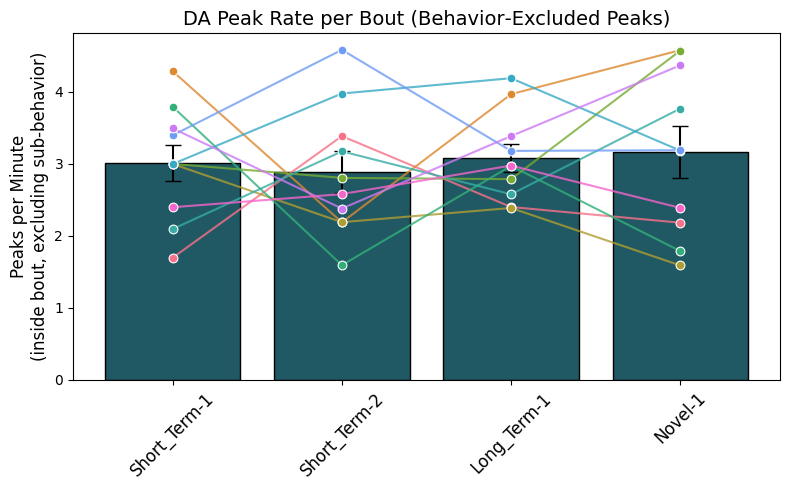

In [97]:
# ───── 1) Compute and plot “Peak Rate (peaks/min)” per Bout ─────────────────────

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy.signal import find_peaks

# (Assumes `experiment` has already been processed as in the previous block:
#   default_batch_process(), group_extract_manual_annotations(...), compute_all_da_metrics(...))

# 1a) Build `bout_bounds_df` (one row per Subject × Bout with start/end times)
bout_definitions = [
    {'prefix': 'Short_Term', 'introduced': 'Short_Term_Introduced', 'removed': 'Short_Term_Removed'},
    {'prefix': 'Long_Term', 'introduced': 'Long_Term_Introduced', 'removed': 'Long_Term_Removed'},
    {'prefix': 'Novel', 'introduced': 'Novel_Introduced', 'removed': 'Novel_Removed'}
]

bout_bounds_df = experiment.get_bout_boundaries_df(bout_definitions)

# 1b) Build a DataFrame of all spontaneous peaks
def detect_spontaneous_events(timestamps, signal,
                              threshold_factor=2.0,
                              min_distance_s=0.5,
                              min_width_s=0.3):
    med = np.median(signal)
    mad = np.median(np.abs(signal - med))
    thresh = med + threshold_factor * mad

    dt = np.median(np.diff(timestamps))
    min_dist_samples  = int(np.round(min_distance_s / dt))
    min_width_samples = int(np.round(min_width_s    / dt))

    peaks, props = find_peaks(
        signal,
        height=thresh,
        distance=min_dist_samples,
        width=min_width_samples
    )
    peak_times  = timestamps[peaks]
    peak_amps   = signal[peaks]
    peak_widths = props["widths"] * dt
    return peak_times, peak_amps, peak_widths

def build_event_dataframe(experiment,
                          threshold_factor=2.0,
                          min_distance_s=0.5,
                          min_width_s=0.3):
    rows = []
    for trial_name, trial in experiment.trials.items():
        subj = trial.subject_name
        ts   = np.array(trial.timestamps)
        sig  = np.array(trial.zscore)
        peak_times, peak_amps, peak_widths = detect_spontaneous_events(
            ts, sig,
            threshold_factor=threshold_factor,
            min_distance_s=min_distance_s,
            min_width_s=min_width_s
        )
        for t, a, w in zip(peak_times, peak_amps, peak_widths):
            rows.append({
                "Subject"   : subj,
                "Trial"     : trial_name,
                "Event_Time": float(t),
                "Amplitude" : float(a),
                "Width_s"   : float(w)
            })
    return pd.DataFrame(rows)

short_cutoffs = {}
for subj in bout_bounds_df['Subject'].unique():
    # find the row where Bout == 'Short_Term-1' for this subject
    row = bout_bounds_df[
        (bout_bounds_df['Subject'] == subj) & 
        (bout_bounds_df['Bout'] == 'Short_Term-1')
    ]
    if not row.empty:
        # bout_start_s is the start of Short_Term-1
        start_s = float(row['Bout_Start_s'].iloc[0])
        short_cutoffs[subj] = start_s + 300.0  # 5 minutes = 300 s
    else:
        # if no Short_Term-1 found, effectively drop all peaks (set cutoff = 0)
        short_cutoffs[subj] = 0.0
peaks_df = build_event_dataframe(experiment)

# 1c) Build a dictionary of all behavior intervals (to exclude behavior‐locked peaks)
behavior_rows = []
for trial_name, trial in experiment.trials.items():
    subj = trial.subject_name
    dfb = trial.behaviors
    if dfb is None or dfb.empty:
        continue
    for _, row in dfb.iterrows():
        behavior_rows.append({
            'Subject'    : subj,
            'Bout'       : row['Bout'],
            'Event_Start': float(row['Event_Start']),
            'Event_End'  : float(row['Event_End'])
        })
behavior_df = pd.DataFrame(behavior_rows)

sub_behavior_intervals = defaultdict(list)
for _, row in behavior_df.iterrows():
    key = (row['Subject'], row['Bout'])
    sub_behavior_intervals[key].append((row['Event_Start'], row['Event_End']))

# 1d) Filter out any peak that falls inside a behavior interval
keep_mask = np.zeros(len(peaks_df), dtype=bool)
peak_subjects = peaks_df['Subject'].to_numpy()
peak_times    = peaks_df['Event_Time'].to_numpy()

bout_subs   = bout_bounds_df['Subject'].to_numpy()
bout_labels = bout_bounds_df['Bout'].to_numpy()
bout_starts = bout_bounds_df['Bout_Start_s'].to_numpy()
bout_ends   = bout_bounds_df['Bout_End_s'].to_numpy()

for i in range(len(peaks_df)):
    subj = peak_subjects[i]
    t    = peak_times[i]
    subj_rows = np.where(bout_subs == subj)[0]
    if len(subj_rows) == 0:
        continue
    kept_this_peak = False
    for j in subj_rows:
        b0  = float(bout_starts[j])
        b1  = float(bout_ends[j])
        lbl = bout_labels[j]
        if (t >= b0) and (t <= b1):
            drop_for_behavior = False
            for (e0, e1) in sub_behavior_intervals[(subj, lbl)]:
                if (t >= e0) and (t <= e1):
                    drop_for_behavior = True
                    break
            if not drop_for_behavior:
                kept_this_peak = True
            break
    keep_mask[i] = kept_this_peak

filtered_peaks = peaks_df[keep_mask].copy()

# 1e) Compute “peaks per minute” for each Subject × Bout
subjects_list = sorted(peaks_df['Subject'].unique())

rate_dict = {bout: {} for bout in bouts_list}
for subj in subjects_list:
    subp = filtered_peaks[filtered_peaks['Subject'] == subj]
    subj_bb = bout_bounds_df[bout_bounds_df['Subject'] == subj]
    for bout in bouts_list:
        row = subj_bb[subj_bb['Bout'] == bout]
        if row.empty:
            rate_dict[bout][subj] = np.nan
            continue
        b0 = float(row['Bout_Start_s'].iloc[0])
        b1 = float(row['Bout_End_s'].iloc[0])
        dur_s = b1 - b0
        if dur_s <= 0:
            rate_dict[bout][subj] = np.nan
            continue
        count_peaks = np.sum((subp['Event_Time'] >= b0) & (subp['Event_Time'] <= b1))
        # peaks per minute = count / (duration in minutes)
        rate_dict[bout][subj] = count_peaks / (dur_s / 60.0)

rate_df = pd.DataFrame(rate_dict).T  # index=bout, columns=subject
rate_df = rate_df[subjects_list]

# 1f) Plot “Peaks per Minute” in each Bout
plt.figure(figsize=(8, 5))
x     = np.arange(len(bouts_list))
bar_w = 0.6

rate_means = rate_df.mean(axis=1)
rate_sems  = rate_df.sem(axis=1)

sns.barplot(
    x=bouts_list, y=rate_means.values,
    yerr=rate_sems.values,
    color=brain_region,
    edgecolor='black',
    capsize=0.1
)
plt.errorbar(
    x, rate_means.values,
    yerr=rate_sems.values,
    fmt='none',
    ecolor='black',
    capsize=6,
    linewidth=1.2
)

palette = sns.color_palette("husl", len(subjects_list))
subject_colors = dict(zip(subjects_list, palette))

for subj in subjects_list:
    y = rate_df.loc[:, subj].values
    plt.plot(
        x, y,
        '-', color=subject_colors[subj],
        linewidth=1.5, alpha=0.8
    )
    plt.scatter(
        x, y,
        color=subject_colors[subj],
        s=40,
        edgecolor='white',
        linewidth=0.8,
        zorder=5
    )

plt.xticks(x, bouts_list, rotation=45, fontsize=12)
plt.ylabel('Peaks per Minute\n(inside bout, excluding sub‐behavior)', fontsize=12)
plt.title('DA Peak Rate per Bout (Behavior‐Excluded Peaks)', fontsize=14)
plt.tight_layout()
plt.show()


In [98]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # ── PARAMETERS ──────────────────────────────────────────────────────────────
# bouts           = ['s1-1','s1-2','s1-3','s1-4','s1-5','s2-1']
# entry_before    = 3.6   # seconds before bout start
# entry_after     = 1.0   # seconds after bout start
# subjects        = peaks_df['Subject'].unique()

# # ── 1) filter peaks after initial cutoff ─────────────────────────────────────
# peaks_cut = peaks_df[peaks_df['Event_Time'] >= 30]  # drop first 30 s

# # ── 2) compute mean peak amplitude in the entry window around bout start ────
# amps = {bout: {} for bout in bouts}

# for subj in subjects:
#     subp = peaks_cut[peaks_cut['Subject'] == subj]
#     for bout in bouts:
#         # get bout start for this subject & bout
#         bb = bout_bounds_df[
#             (bout_bounds_df['Subject'] == subj) &
#             (bout_bounds_df['Bout']    == bout)
#         ]
#         vals = []
#         for _, row in bb.iterrows():
#             start = row['Bout_Start_s']
#             # select peaks in [start - before, start + after]
#             window_mask = (
#                 (subp['Event_Time'] >= start - entry_before) &
#                 (subp['Event_Time'] <= start + entry_after)
#             )
#             vals.extend(subp.loc[window_mask, 'Amplitude'].tolist())
#         # mean amplitude (NaN if no peaks)
#         amps[bout][subj] = np.nanmean(vals) if vals else np.nan

# # ── 3) build DataFrame ──────────────────────────────────────────────────────
# amp_df = pd.DataFrame(amps)  # rows=subjects, cols=bouts

# # ── 4) compute group mean ± SEM ──────────────────────────────────────────────
# means = amp_df.mean(axis=0)
# sems  = amp_df.sem(axis=0)

# # ── 5) choose colors for each subject ────────────────────────────────────────
# palette = sns.color_palette("husl", len(subjects))
# subject_colors = dict(zip(subjects, palette))

# # ── 6) plot ─────────────────────────────────────────────────────────────────
# fig, ax = plt.subplots(figsize=(8,5))
# x     = np.arange(len(bouts))
# bar_w = 0.6

# # grey bars = group mean ± SEM
# ax.bar(
#     x, means,
#     yerr=sems,
#     capsize=6,
#     width=bar_w,
#     color='lightgray',
#     edgecolor='black',
#     linewidth=1.5
# )

# # one line + dot per mouse
# for subj in subjects:
#     y = amp_df.loc[subj, bouts].values
#     ax.plot(
#         x, y,
#         '-',
#         color=subject_colors[subj],
#         linewidth=1.5, alpha=0.8
#     )
#     ax.scatter(
#         x, y,
#         color=subject_colors[subj],
#         s=50,
#         edgecolor='white',
#         linewidth=0.8,
#         zorder=5
#     )

# # cosmetics
# ax.set_xticks(x)
# ax.set_xticklabels(bouts, rotation=45, fontsize=12)
# ax.set_ylabel('Peak Amplitude (z-score ΔF/F)', fontsize=12)
# ax.set_title('Mean Peak Amplitude during Entry Windows\n(–3.6 s → +1 s)', fontsize=14)
# plt.tight_layout()
# plt.show()


C:\Users\alber\AppData\Local\Temp\ipykernel_37988\1322051006.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(subjects))


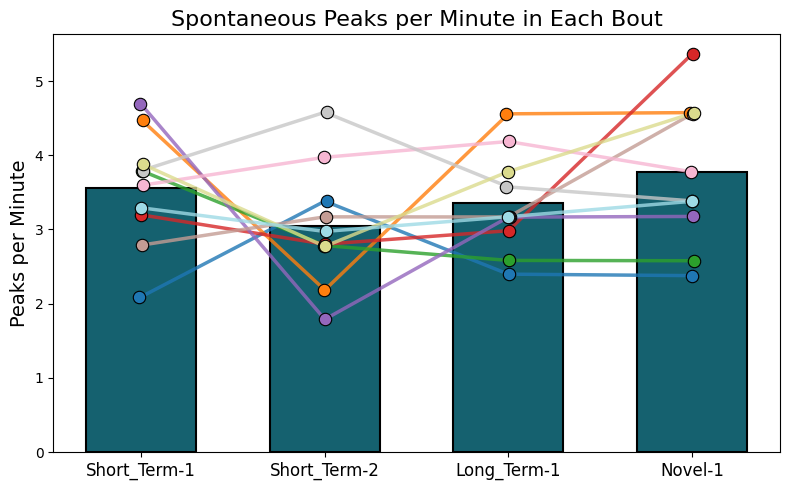

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1) Define which bouts to include, in order

# --- 2) Drop the first 30 s and restrict to your peaks
peaks_df = peaks_df[peaks_df.Event_Time >= 30]

# --- 3) Build a table of peaks-per-minute per bout per subject
subjects = peaks_df['Subject'].unique()
rates = {bout: {} for bout in bouts}

for subj in subjects:
    subp = peaks_df[peaks_df.Subject == subj]
    for bout in bouts:
        # grab that subject’s bout window(s)
        bb = bout_bounds_df[
            (bout_bounds_df.Subject == subj) &
            (bout_bounds_df.Bout    == bout)
        ]
        # there should normally be one row per bout:
        total_peaks = 0
        total_time_s = 0
        for _, row in bb.iterrows():
            t0 = row.Bout_Start_s
            t1 = row.Bout_End_s
            total_peaks   += ((subp.Event_Time >= t0) & (subp.Event_Time <= t1)).sum()
            total_time_s  += (t1 - t0)
        # convert to “per minute”
        if total_time_s > 0:
            rates[bout][subj] = total_peaks / (total_time_s / 60)
        else:
            rates[bout][subj] = 0.0

# rows=bouts, cols=subjects
rate_df = pd.DataFrame(rates).T  # shape (6, n_subjects)

# --- 4) Compute the group‐mean rate for each bout
mean_rate = rate_df.mean(axis=1)

# --- 5) Pick one color per mouse
cmap = plt.cm.get_cmap("tab20", len(subjects))
subject_colors = {s: cmap(i) for i, s in enumerate(subjects)}

# --- 6) Plot
fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(len(bouts))
bar_width = 0.6

# a) light‐gray bars = mean peaks/min
ax.bar(x, mean_rate, width=bar_width,
       color=brain_region, edgecolor="k", linewidth=1.5)

# b) connect each mouse’s rate across bouts
for subj in subjects:
    y = rate_df[subj].values
    ax.plot(x, y, '-', color=subject_colors[subj],
            lw=2.5, alpha=0.8, zorder=3)

# c) overlay each mouse’s dot
for i, bout in enumerate(bouts):
    for subj in subjects:
        y = rate_df.loc[bout, subj]
        jitter = np.random.uniform(-bar_width*0.02, bar_width*0.02)
        ax.scatter(i + jitter, y,
                   color=subject_colors[subj],
                   s=80, edgecolor="k", linewidth=0.8,
                   zorder=4, label=subj)

# d) clean up legend (one entry per subject)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# ax.legend(by_label.values(), by_label.keys(),
#           title="Subject", bbox_to_anchor=(1.02,1),
#           loc="upper left", frameon=False)

# e) axis labels & title
ax.set_xticks(x)
ax.set_xticklabels(bouts, fontsize=12)
ax.set_ylabel("Peaks per Minute", fontsize=14)
ax.set_title("Spontaneous Peaks per Minute in Each Bout", fontsize=16)
plt.tight_layout()
plt.show()
# Average amplitude per bout

In [100]:
#import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) define your ordered bouts
bouts = ['s1-1','s1-2','s1-3','s1-4','s1-5','s2-1']

# 2) build list of segment labels in order: bout, bout_ITI, bout2, bout2_ITI, ...
segments = []
for b in bouts:
    segments.append(b)
    segments.append(f"{b}_ITI")

# 3) filter peaks after the 30 s cut
peaks_df = peaks_df[peaks_df.Event_Time >= 30].copy()
subjects = peaks_df.Subject.unique()

# 4) initialize a dict of dicts: pct[segment][subject]
pct = {seg: {} for seg in segments}

# 5) for each subject, compute
for subj in subjects:
    subp = peaks_df[peaks_df.Subject==subj]
    total_peaks = len(subp)
    # get that subj's ordered bout boundaries
    sb = bout_bounds_df[bout_bounds_df.Subject==subj].copy()
    sb = sb.set_index('Bout').loc[bouts]  # ensure same order
    
    # also find recording end
    tr = experiment.trials[next(iter(experiment.trials))]  # any trial
    rec_end = tr.timestamps[-1]
    
    # loop through bouts
    for i, bout in enumerate(bouts):
        # bout window
        start = sb.loc[bout,'Bout_Start_s']
        end   = sb.loc[bout,'Bout_End_s']
        cnt   = ((subp.Event_Time>=start)&(subp.Event_Time<=end)).sum()
        pct[bout][subj] = cnt/total_peaks*100 if total_peaks else 0
        
        # now ITI window: from this bout's end to next bout's start (or rec_end)
        next_start = (sb.loc[bouts[i+1],'Bout_Start_s']
                      if i+1 < len(bouts) else rec_end)
        # exclude the instant before next_start
        mask = (subp.Event_Time> end) & (subp.Event_Time< next_start)
        cnt2 = mask.sum()
        pct[f"{bout}_ITI"][subj] = cnt2/total_peaks*100 if total_peaks else 0

# 6) make DataFrame: rows=segments, cols=subjects
count_df = pd.DataFrame(pct).T.loc[segments]

# 7) compute group means
mean_pct = count_df.mean(axis=1)

# 8) pick distinct colors for mice
cmap = plt.cm.get_cmap("tab20", len(subjects))
subject_colors = {subj: cmap(i) for i, subj in enumerate(subjects)}

# 9) plot
fig, ax = plt.subplots(figsize=(10,5))
x = np.arange(len(segments))
bar_w = 0.8

# a) grey bars = group means
ax.bar(x, mean_pct, width=bar_w,
       color="lightgray", edgecolor="black", lw=1.5)

# b) lines per mouse
for subj in subjects:
    ys = count_df[subj].values
    ax.plot(x, ys, color=subject_colors[subj], lw=2.5, alpha=0.8, zorder=3)

# c) dots per mouse
for i, seg in enumerate(segments):
    for subj in subjects:
        y = count_df.loc[seg, subj]
        jitter = np.random.uniform(-bar_w*0.02, bar_w*0.02)
        ax.scatter(i + jitter, y,
                   color=subject_colors[subj],
                   s=80, edgecolor="black", lw=0.8,
                   zorder=4, label=subj)

# d) legend with one entry per mouse
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),
          title="Subject", bbox_to_anchor=(1.02,1),
          loc="upper left", frameon=False)

# e) cosmetics
ax.set_xticks(x)
ax.set_xticklabels(segments, rotation=45, ha="right", fontsize=10)
ax.set_ylabel("% of Peaks", fontsize=12)
ax.set_title("Percent of Each Mouse’s Peaks During Each Bout and Its ITI", fontsize=14)
plt.tight_layout()
plt.show()


KeyError: "None of [Index(['s1-1', 's1-2', 's1-3', 's1-4', 's1-5', 's2-1'], dtype='object', name='Bout')] are in the [index]"

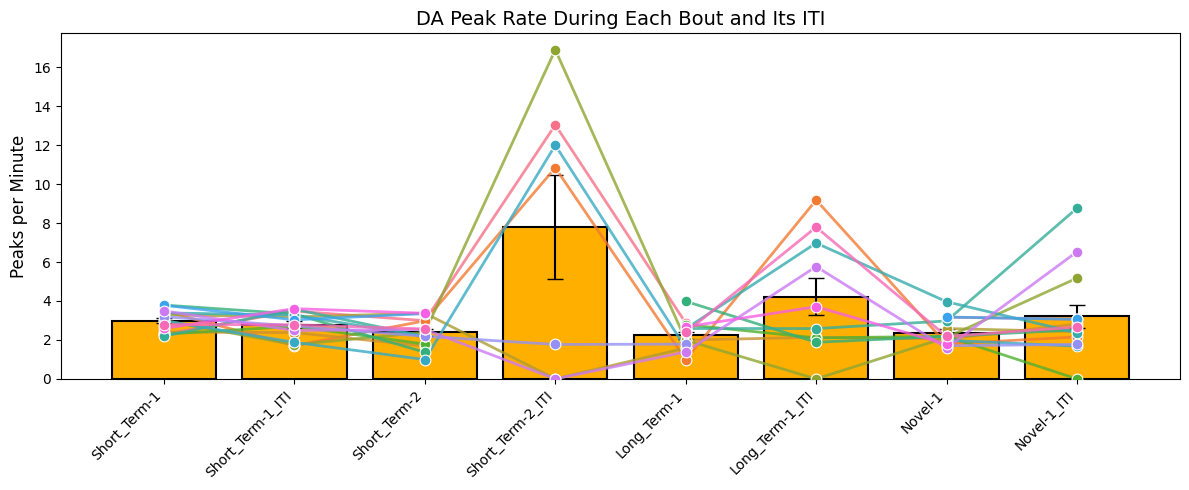

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) define your ordered bouts

# 2) build list of segment labels in order: bout, bout_ITI, bout2, bout2_ITI, ...
segments = []
for b in bouts:
    segments.append(b)
    segments.append(f"{b}_ITI")

# 3) filter peaks after the 30 s cut
peaks_cut = peaks_df[peaks_df.Event_Time >= 30].copy()
subjects  = peaks_cut.Subject.unique()

# 4) initialize a dict of dicts: rates[segment][subject]
rates = {seg: {} for seg in segments}

# 5) for each subject, compute peaks/min for each segment
for subj in subjects:
    subp = peaks_cut[peaks_cut.Subject == subj]
    # get this subj’s bouts in the correct order
    sb = bout_bounds_df[bout_bounds_df.Subject == subj].set_index('Bout').loc[bouts]
    # find end of recording to cap the last ITI
    any_trial = next(iter(experiment.trials.values()))
    rec_end   = any_trial.timestamps[-1]

    for i, bout in enumerate(bouts):
        # —— BOUT itself
        start = sb.loc[bout, 'Bout_Start_s']
        end   = sb.loc[bout, 'Bout_End_s']
        dur_s = end - start
        cnt   = ((subp.Event_Time >= start) & (subp.Event_Time <= end)).sum()
        # convert to per‐minute
        rates[bout][subj] = (cnt / dur_s * 60) if dur_s > 0 else np.nan

        # —— ITI: from this bout’s end to next bout’s start (or rec_end)
        next_start = sb.loc[bouts[i+1], 'Bout_Start_s'] if i+1 < len(bouts) else rec_end
        dur_iti    = next_start - end
        cnt_iti    = ((subp.Event_Time > end) & (subp.Event_Time < next_start)).sum()
        rates[f"{bout}_ITI"][subj] = (cnt_iti / dur_iti * 60) if dur_iti > 0 else np.nan

# 6) build DataFrame: index=subjects, cols=segments
rates_df = pd.DataFrame(rates).T.loc[segments].T

# 7) compute group mean ± SEM for each segment
means = rates_df.mean(axis=0)
sems  = rates_df.sem(axis=0)

# 8) pick distinct colors per mouse
import seaborn as sns
palette = sns.color_palette("husl", len(subjects))
subject_colors = dict(zip(subjects, palette))

# 9) plot
fig, ax = plt.subplots(figsize=(12,5))
x     = np.arange(len(segments))
bar_w = 0.8

# a) grey bars = group mean ± SEM
ax.bar(x, means, width=bar_w, yerr=sems, capsize=6,
       color=brain_region, edgecolor="black", linewidth=1.5)

# b) lines + dots per subject
for subj in subjects:
    y = rates_df.loc[subj, segments].values
    ax.plot(x, y, '-', color=subject_colors[subj], linewidth=2, alpha=0.8)
    ax.scatter(x, y, color=subject_colors[subj], s=60,
               edgecolor='white', linewidth=0.8, zorder=5)

# c) cosmetics
ax.set_xticks(x)
ax.set_xticklabels(segments, rotation=45, ha="right", fontsize=10)
ax.set_ylabel('Peaks per Minute', fontsize=12)
ax.set_title("DA Peak Rate During Each Bout and Its ITI", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd

# assume:
#   peaks_df       with ['Subject','Trial','Event_Time',…]
#   bout_bounds_df with ['Subject','Bout_Start_s','Bout_End_s']
#   experiment     your Experiment instance

# 1) Restrict to “in‐bout” peaks
peaks_in_bouts = []
for subj, subp in peaks_df.groupby('Subject'):
    bouts = bout_bounds_df[bout_bounds_df.Subject==subj][['Bout_Start_s','Bout_End_s']].values
    mask = np.zeros(len(subp), dtype=bool)
    for t0, t1 in bouts:
        mask |= (subp.Event_Time >= t0) & (subp.Event_Time <= t1)
    peaks_in_bouts.append(subp[mask])
peaks_in_bouts_df = pd.concat(peaks_in_bouts, ignore_index=True)

# 2) Gather all behavior‐onset times per mouse
behavior_onsets = {}
for trial_name, trial in experiment.trials.items():
    subj = trial.subject_name
    if trial.behaviors is None or trial.behaviors.empty:
        continue
    behavior_onsets.setdefault(subj, []).extend(trial.behaviors['Event_Start'].tolist())

# 3) Compute % of in‐bout peaks in [0,4] s after each onset
window_post = 4.0  # seconds after onset
results = []
for subj in peaks_in_bouts_df.Subject.unique():
    subp = peaks_in_bouts_df[peaks_in_bouts_df.Subject==subj]
    total_peaks = len(subp)
    if total_peaks == 0:
        pct = np.nan
    else:
        times = subp['Event_Time'].values
        mask = np.zeros(total_peaks, dtype=bool)
        for onset in behavior_onsets.get(subj, []):
            mask |= (times >= onset) & (times <= onset + window_post)
        pct = mask.sum() / total_peaks * 100
    results.append({'Subject': subj, f'Pct_Peaks_0to{int(window_post)}s': pct})

pct_df = pd.DataFrame(results)
print(pct_df)


   Subject  Pct_Peaks_0to4s
0       p1        45.454545
1       p2        46.511628
2       p3        27.272727
3       p5        15.625000
4       p6        25.000000
5       p7        26.923077
6       p8        13.793103
7      pp1        28.000000
8      pp2         9.523810
9      pp3        30.769231
10     pp4        28.571429
11     pp5        30.769231
12     pp6         8.571429
13     pp7        27.586207
14     pp8        21.212121
